## 1. Environment preparation
- All of the codes in our experiment were written so that they can be run in a Google Colab environment
- Specific version of PyTorch and HuggingFace set for consistency between our team's different environments
- Beside this "cleaned" version, our entire experiment codes and raw data can be found in our group's Github: https://github.com/hmhamad/CSCI699-HW1

In [ ]:
# Installing Huggingface library to load the weights from different pre-trained RoBERTa models

!pip install transformers==4.11.3
!pip install torch==1.10.2

     |████████████████████████████████| 2.9 MB 15.0 MB/s 
     |████████████████████████████████| 895 kB 82.6 MB/s 
     |████████████████████████████████| 3.3 MB 83.1 MB/s 
     |████████████████████████████████| 596 kB 86.5 MB/s 
     |████████████████████████████████| 67 kB 6.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |██████████████████████████████▎ | 834.1 MB 1.1 MB/s eta 0:00:43tcmalloc: large alloc 1147494400 bytes == 0x55d407ea6000 @  0x7ff08d7fa615 0x55d3a2e673bc 0x55d3a2f4818a 0x55d3a2e6a1cd 0x55d3a2f5cb3d 0x55d3a2ede458 0x55d3a2ed902f 0x55d3a2e6baba 0x55d3a2ede2c0 0x55d3a2ed902f 0x55d3a2e6baba 0x55d3a2edacd4 0x55d3a2f5d986 0x55d3a2eda350 0x55d3a2f5d986 0x55d3a2eda350 0x55d3a2f5d986 0x55d3a2eda350 0x55d3a2e6bf19 0x55d3a2eafa79 0x55d3a2e6ab32 0x55d3a2ede1dd 0x55d3a2ed902f 0x55d3a2e6baba 0x55d3a2edacd4 0x55d3a2ed902f 0x55d3a2e6baba 0x55d3a2ed9eae 0x55d3a2e6b9da

In [ ]:
import dill
import glob
import json
import os
import time

from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from tqdm import tqdm
from transformers import RobertaModel, RobertaTokenizer

## 2. Loading & tokenizing ACL-ARC dataset from raw jsonl files for fine-tuning RoBERTa on a downstream classification task (citation intent classification)
  - Number of training documents: 1,688
  - Number of test documents: 139
  - Number of classes (types of citation intents): 6

In [ ]:
TRAIN_PATH = "./data/citation_intent/train.jsonl"
TEST_PATH = "./data/citation_intent/test.jsonl"

def load_json(json_path, text_key='text', label_key='label'):
  """
  Converts the raw jsonl data file into 
  two lists: input texts and their respective labels
  """
  X = []
  Y = []
  with open(json_path, 'r') as f:
    for line in f:
      raw_json = json.loads(line)
      X.append(raw_json[text_key])
      Y.append(raw_json[label_key])
  return X, Y

trainX, trainY = load_json(TRAIN_PATH)
testX, testY = load_json(TEST_PATH)
num_classes = len(set(trainY))

## Summary statistics of the input data
print("# of total sentences:", len(trainX), len(testX))
print("An example sentence:", trainX[2])
print('# of labels:', num_classes)

# of total sentences: 1688 139
An example sentence: She evaluates 3,000 German verbs with a token frequency between 10 and 2,000 against the Duden ( Dudenredaktion 2001 ) .
# of labels: 6


- For all RoBERTa models in our experiment, the raw text data will be tokenized and encoded by RoBERTa tokenizer provided in Huggingface
- RoBERTa tokenizer uses a Byte-Pair encoding on 50K subword units
- All of the sentences are either padded or truncated to contain 512 tokens to match the output dimensions of RoBERTa

In [ ]:
def convert_txt2tokenid(tokenizer, text):
  """
  Uses the loaded tokenizer from HuggingFace to tokenize the raw text into int index
  return tokenized torch array
  """
  token_ids = []
  for sent in text:
    ## max_length = 512
    token_ids.append(tokenizer.encode(sent, padding='max_length', return_tensors = 'pt'))
  return torch.cat(token_ids, dim=0)

# Tokenizers used in the domain adapted versions of RoBERTa are identical to roberta-base
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

encoded_trainX = convert_txt2tokenid(roberta_tokenizer, trainX)
encoded_testX = convert_txt2tokenid(roberta_tokenizer, testX)

# Transforming our labels into int indices
label_encoder = preprocessing.LabelEncoder()

encoded_trainY = label_encoder.fit_transform(trainY)
encoded_testY = label_encoder.transform(testY)

encoded_trainY = torch.tensor(encoded_trainY)
encoded_testY = torch.tensor(encoded_testY)

# 0 represents the "start of a sentence" tag, while 1 represents a padding.
print(encoded_trainX[0])
print(encoded_trainY[0])

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/185 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/430 [00:00<?, ?B/s]

tensor([    0, 42702,  2156,    81,     5,   375,   367,   107,  2156,   552,
           19,  9766,    11,     5,   304,     9,  2239,     8, 17325,  6448,
           13,  3857,     9,   455, 28564,   268,    36,  5415,  2156,  7528,
        25606,   732,  4422, 20082,  2156,  7528,   102, 25606,   732,  4422,
        20082,  2156,  7528,   428, 25606, 12041,   282,  1115,  3994,  3592,
         2156,  7528,  4839,  2156,  1233,  2017,    34,    57,   156,    15,
            5,   304,     9, 17325,  2239,  6448,     7,  5281, 16762, 46563,
         8117, 45774, 28201, 22810,    50,  1617,    14,  4064,    11,    10,
        45774, 28201,  1291,    36,  2197,  2156, 11151, 25606,  3513, 18086,
            8,  7380,  2156,  7969, 25606, 19021, 22704,  4400,  1076,     4,
         2156,  6708, 25606,  5866,   324,     8, 13891,  2156,  6708, 25606,
         6760,  3979,  4400,  1076,     4,  2156,  6193, 25606, 14687,   219,
          677,   260,  1638,     8, 13880,  2156,  5155, 25606, 

- The encoded training and test datasets created as PyTorch dataloaders
- Batch size set is fixed at 16 as indicated in the original 'Don't Stop Pretraining' paper

In [ ]:
# LM_TYPE is used to denote the type of pre-trained RoBERTa to be used in each run
# In our experiment the following three variants of RoBERTa has been used
# For raw RoBERTa = "roberta-base"
# For RoBERTa + CS DAPT (in-domain adapatation) = "allenai/cs_roberta_base"
# For RoBERTa + NEWS DAPT (out-of-domain adaptation) = "allenai/news_roberta_base"

LM_TYPE = "allenai/cs_roberta_base"
batch_size = 16

# The performace of the fine-tuning each RoBERTa model was extremely sensitive to the choice of the random seed
# Among multiple runs, we provide the random seeds used in our final visualization

if LM_TYPE == "allenai/cs_roberta_base":
  torch.manual_seed(7400714831134151359)
elif LM_TYPE == "allenai/news_roberta_base":
  torch.manual_seed(6043471812276002753)
else:
  torch.manual_seed(42) # Only this seed is previously released in the original Don't Stop Pretraining github
  

train_dataset = TensorDataset(encoded_trainX, encoded_trainY)
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

test_dataset = TensorDataset(encoded_testX, encoded_testY)
test_dataloader = DataLoader(
            test_dataset,
            sampler = RandomSampler(test_dataset),
            batch_size = batch_size
        )

## 3. Defining and fine-tuning a RoBERTa model for the citation intent classification
- On top of each RoBERTa layer, a single feedforward layer for classification is added
- This feedforward layer only takes in the ``[CLS]`` token as the input
- Once again, the hyperparameters of this additional feedforward layer is set and as described in "Don't Stop Pretraining" paper (Table 14)
  - Number of epochs: 10
  - Learning rate of Adam: 2e-5
  - Dropout: 0.1
  - Feedforwad nonlinearity: tanh

In [ ]:
class CustomRoberta(nn.Module):
    def __init__(self, num_classes = num_classes):
          super(CustomRoberta, self).__init__()
          ## output_attentions and output_hidden_states were set as True to retrieve all of the weights in the model
          self.robert = RobertaModel.from_pretrained(LM_TYPE, output_attentions = True, output_hidden_states = True)
          self.linear = nn.Linear(768, 768)
          self.classification = nn.Linear(768, num_classes)
          self.dropout = nn.Dropout(0.1)
          self.activation = nn.Tanh()

    def forward(self, ids):
          # index 1 represents the pooled_output, the cls token.
          sequence_output = self.robert(ids)[1]
          
          dropout = self.dropout(sequence_output)
          linear_output = self.linear(dropout)
          temp = self.activation(linear_output)
          output = self.classification(temp)

          return output

model = CustomRoberta(num_classes = num_classes)
model.cuda()

Downloading:   0%|          | 0.00/625M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/cs_roberta_base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomRoberta(
  (robert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

- Loading some of Umang's template codes for visualizations
- Slight revisions to the codes were commented

In [ ]:
def count_params(model: torch.nn.Module, skip_bn_bias=False):
    count = 0
    for param in model.parameters():
        if param.requires_grad:
            if param.dim() <= 1 and skip_bn_bias:
                pass
            else:
                count += param.numel()
    return count

def flatten_grads(model, num_params, skip_bn_bias=False):
    flat_grads = torch.zeros(num_params, requires_grad=False)
    idx = 0
    for param in model.parameters():
        if param.requires_grad:
            if param.dim() <= 1 and skip_bn_bias:
                pass
            else:
                flat_grads[idx:idx + param.numel()] = torch.flatten(param.grad).data.cpu()
                idx += param.numel()
    return flat_grads

def get_loss_value(model, loader, device, cal_f1=True):
    """
    Evaluation loop for the multi-class classification problem.
    return (loss, accuracy)
    """
    model.eval()
    losses = []
    accuracies = []
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs, labels, reduce=None).detach()
            losses.append(loss.reshape(-1))
            preds = torch.argmax(outputs, dim=1)
            acc = (preds == labels).float().detach()
            pred_labels+=preds.detach().cpu().tolist()
            true_labels+=labels.detach().cpu().tolist()
            accuracies.append(acc.reshape(-1))

        losses = torch.cat(losses, dim=0).mean().cpu().data.numpy()
        accuracies = torch.cat(accuracies, dim=0).mean().cpu().data.numpy()

        ## As the original paper used the macro F1 score to evaluate the fine-tuned models
        ## additional argument (cal_f1) defined to calculate macro F1 score within this function
        if cal_f1:
          p_macro, r_macro, f1_macro, support_macro = \
                  precision_recall_fscore_support(y_true=np.array(true_labels), y_pred=np.array(pred_labels), average='macro')
          return losses, accuracies, p_macro, r_macro, f1_macro
        else:
          return losses, accuracies


def flatten_params(model, num_params, skip_bn_bias=False):
    flat_param = torch.zeros(num_params, requires_grad=False)
    idx = 0
    for param in model.parameters():
        if param.requires_grad:
            if param.dim() <= 1 and skip_bn_bias:
                pass
            else:
                flat_param[idx:idx + param.numel()] = torch.flatten(param).data.cpu()
                idx += param.numel()
    return flat_param

def set_weights_by_direction(model, x, y, direction1, direction2, weights, skip_bn_bias=False):
    if direction2 is not None:
        changes = direction1 * x + direction2 * y
    else:
        changes = direction1 * x

    apply_params(model, weights + changes, skip_bn_bias=skip_bn_bias)

def apply_params(model, array, skip_bn_bias=False):
    idx = 0
    for param in model.parameters():
        if param.requires_grad:
            if param.dim() <= 1 and skip_bn_bias:
                pass
            else:
                param.data = (array[idx:idx + param.numel()]).reshape(param.data.shape)
                idx += param.numel()
    return model


In [ ]:
## Epochs and optimizer settings followed the settings in the original paper
epochs = 10
optimizer = Adam(model.parameters(), lr = 2e-5)

RESULT_FOLDER = "./data"
os.makedirs(f"{RESULT_FOLDER}/new_seed_ckpt", exist_ok=True)

device = torch.device("cuda")
total_params = count_params(model, skip_bn_bias=True)
t0 = time.time()

for epoch in range(epochs):
  model.train()
  epoch_start = time.time()

  for i, batch in enumerate(train_dataloader):

    d_input_id = batch[0].to(device)
    d_labels = batch[1].to(device)
    outputs = model(d_input_id)
    loss = torch.nn.functional.cross_entropy(outputs, d_labels)

    model.zero_grad()
    loss.backward()
    optimizer.step()

  loss, acc, prec, recall, f1 = get_loss_value(model, test_dataloader, device=device)

  print("For epoch #%d: took %f seconds" %(epoch+1, time.time()-epoch_start)) 
  print("\t Loss: %f, Accuracy on the test dataset: %f" %(loss, acc))
  print("\t prec: %f, recall: %f, macro f1: %f" %(prec, recall, f1))
  
  torch.save(
      model.state_dict(), f'{RESULT_FOLDER}/new_seed_ckpt/{epoch + 1}_model.pt',
      pickle_module=dill
  )

training_time = time.time() - t0

## When the frequent directions algorithm is used,
## approximately 34000 seconds (9.5 hours) are required for a single fine-tuning experiment
## As multiple fine-tuning experiments were required for finding an ideal random seed in each of our experiment setting
## we chose PCA given its shorter computation time

print("The entire training took: %f" %(training_time))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #1: took 51.378764 seconds
	 Loss: 1.366758, Accuracy on the test dataset: 0.510791
	 prec: 0.085132, recall: 0.166667, macro f1: 0.112698


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #2: took 51.446758 seconds
	 Loss: 1.401326, Accuracy on the test dataset: 0.510791
	 prec: 0.085132, recall: 0.166667, macro f1: 0.112698


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #3: took 51.496300 seconds
	 Loss: 1.357428, Accuracy on the test dataset: 0.510791
	 prec: 0.085132, recall: 0.166667, macro f1: 0.112698


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #4: took 51.527437 seconds
	 Loss: 1.186453, Accuracy on the test dataset: 0.582734
	 prec: 0.184176, recall: 0.271398, macro f1: 0.219071


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #5: took 51.531543 seconds
	 Loss: 1.094334, Accuracy on the test dataset: 0.597122
	 prec: 0.189542, recall: 0.267967, macro f1: 0.222015


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #6: took 51.569949 seconds
	 Loss: 1.121011, Accuracy on the test dataset: 0.582734
	 prec: 0.303584, recall: 0.262286, macro f1: 0.243703


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #7: took 51.646205 seconds
	 Loss: 0.961309, Accuracy on the test dataset: 0.726619
	 prec: 0.583934, recall: 0.485739, macro f1: 0.478162
For epoch #8: took 51.688721 seconds
	 Loss: 0.835635, Accuracy on the test dataset: 0.733813
	 prec: 0.593078, recall: 0.602506, macro f1: 0.584767
For epoch #9: took 51.701327 seconds
	 Loss: 0.922805, Accuracy on the test dataset: 0.719424
	 prec: 0.617230, recall: 0.622841, macro f1: 0.616147
For epoch #10: took 51.670382 seconds
	 Loss: 0.883393, Accuracy on the test dataset: 0.776978
	 prec: 0.684661, recall: 0.663083, macro f1: 0.672268
The entire training took: 530.554392


## [Appendix] Fine-tuning a RoBERTa model while executing the Frequent Directions algorithm
- Left as a refernce in case of additional experiments in the future

In [ ]:
epochs = 10
optimizer = AdamW(model.parameters(), lr = 2e-5)

RESULT_FOLDER = "/content/drive/MyDrive/CS699/data/ROBERTA_CS/"
os.makedirs(f"{RESULT_FOLDER}/ckpt", exist_ok=True)

device = torch.device("cuda")
total_params = count_params(model, skip_bn_bias=True)
fd = FrequentDirectionAccountant(k=2, l=10, n=total_params, device="cpu")
t0 = time.time()

for epoch in range(epochs):
  model.train()
  epoch_start = time.time()

  for i, batch in enumerate(train_dataloader):

    d_input_id = batch[0].to(device)
    d_labels = batch[1].to(device)
    outputs = model(d_input_id)
    loss = torch.nn.functional.cross_entropy(outputs, d_labels)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    fd.update(flatten_grads(model, total_params, skip_bn_bias=True))

  loss, acc = get_loss_value(model, test_dataloader, device=device)

  print("For epoch #%d: took %f seconds" %(epoch, time.time()-epoch_start)) 
  print("\t Loss: %f, Accuracy on the test dataset: %f" %(loss, acc))

  torch.save(
      model.state_dict(), f'{RESULT_FOLDER}/ckpt/{epoch + 1}_model.pt',
      pickle_module=dill
  )

training_time = time.time() - t0
buffer = fd.get_current_buffer()
directions = fd.get_current_directions()
directions = directions.data.numpy()

np.savez(
    f"{RESULT_FOLDER}/dapt_buffer.npy",
    buffer=buffer.cpu().data.numpy(), direction1=directions[0], direction2=directions[1]
)


print("The entire training took: %f" %(training_time))

For epoch #0: took 3297.507746 seconds
	 Loss: 1.387906, Accuracy on the test dataset: 0.510791
For epoch #1: took 3397.643081 seconds
	 Loss: 1.370653, Accuracy on the test dataset: 0.510791
For epoch #2: took 3397.982627 seconds
	 Loss: 1.422634, Accuracy on the test dataset: 0.510791
For epoch #3: took 3390.804078 seconds
	 Loss: 1.357474, Accuracy on the test dataset: 0.510791
For epoch #4: took 3401.652000 seconds
	 Loss: 1.284199, Accuracy on the test dataset: 0.510791
For epoch #5: took 3371.010343 seconds
	 Loss: 1.218668, Accuracy on the test dataset: 0.597122
For epoch #6: took 3393.082956 seconds
	 Loss: 1.200420, Accuracy on the test dataset: 0.604317
For epoch #7: took 3389.962469 seconds
	 Loss: 1.187840, Accuracy on the test dataset: 0.611511
For epoch #8: took 3371.945162 seconds
	 Loss: 1.153005, Accuracy on the test dataset: 0.640288
For epoch #9: took 3368.918130 seconds
	 Loss: 1.126846, Accuracy on the test dataset: 0.683453
The entire training took: 33794.721205


## 4. Computing directions, projections and loss landscapes
- All of the implementation in this section used Umang's starter codes for computing the directions, projections and the loss landscape
- [Minor modification] Due to the memory issue, the existing PCA implementation was switch to incremental PCA, which performs PCA in multiple batches



In [ ]:
def get_PCA_directions(model: nn.Module, state_files, skip_bn_bias):
    """
        Compute PCA direction as defined in Li et al. 2017 (https://arxiv.org/abs/1712.09913)
    :param model: model object
    :param state_files: list of checkpoints.
    :param skip_bn_bias: Skip batch norm and bias while flattening the model params. Li et al. do not use batch norm and bias parameters
    :return: (pc1, pc2, explained variance)
    """

    # load final weights and flatten
    print("Loading: %s" %(state_files[-1]))
    model.load_state_dict(torch.load(state_files[-1], pickle_module=dill, map_location="cpu"))
    total_param = count_params(model, skip_bn_bias=skip_bn_bias)
    w_final = flatten_params(model, total_param, skip_bn_bias=skip_bn_bias)

    # compute w_i- w_final
    w_diff_matrix = np.zeros((len(state_files) - 1, total_param))
    for idx, file in enumerate(state_files[:-1]):
        print(file)
        model.load_state_dict(torch.load(file, pickle_module=dill, map_location="cpu"))
        w = flatten_params(model, total_param, skip_bn_bias=skip_bn_bias)

        diff = w - w_final
        w_diff_matrix[idx] = diff
        del w
        del diff

    # Perform PCA on the optimization path matrix
    print("Performing PCA")

    # Due to the memory issue, traditional PCA has been replaced by incremental PCA, 
    # in which the matrix decomposition is done in a batch
    pca = IncrementalPCA(n_components=2)
    pca.fit(w_diff_matrix)
    pc1 = np.array(pca.components_[0])
    pc2 = np.array(pca.components_[1])
    print(
        f"angle between pc1 and pc2: {np.dot(pc1, pc2) / (np.linalg.norm(pc1) * np.linalg.norm(pc2))}"
    )
    print(f"pca.explained_variance_ratio_: {pca.explained_variance_ratio_}")
    print(f"pca singular values: {pca.singular_values_}")

    return pc1, pc2, pca.explained_variance_ratio_

In [ ]:
CHECKPOINTS_FILES = glob.glob("./data/new_seed_ckpt/*")
ROOT_DIR = "./data/"
PCA_FILE_NAME = 'pca_dir_newseed.npz'

os.makedirs(f"{ROOT_DIR}", exist_ok=True)

direction1, direction2, ex_var = get_PCA_directions(model, CHECKPOINTS_FILES, True)

np.savez(
    f"{ROOT_DIR}/{PCA_FILE_NAME}", explained_variance=ex_var,
    direction2=direction2, direction1=direction1
)


Loading: /content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/10_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/1_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/2_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/3_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/4_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/5_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/6_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/7_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/8_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/9_model.pt
Performing PCA
angle between pc1 and pc2: -6.978792543854622e-15
pca.explained_variance_ratio_: [0.7159183  0.13737737]
pca singular values: [8.8923891  3.89533055]


### Computing trajectories based on the PCA results above

In [ ]:
temp = np.load(ROOT_DIR+PCA_FILE_NAME)
direction1 = torch.tensor(temp["direction1"], device="cpu").float()
direction2 = torch.tensor(temp["direction2"], device="cpu").float()

# To check whether the last checkpoint is properly loaded
print("Loading the last checkpoint: %s" %(CHECKPOINTS_FILES[-1]))
model.load_state_dict(torch.load(CHECKPOINTS_FILES[-1], pickle_module=dill, map_location="cpu"))
total_param = count_params(model, skip_bn_bias=True)
w_final = flatten_params(model, total_param, skip_bn_bias=True)

w_diff_matrix = torch.zeros(len(CHECKPOINTS_FILES) - 1, total_param)
for idx, file in enumerate(CHECKPOINTS_FILES[:-1]):
    model.load_state_dict(torch.load(file, pickle_module=dill, map_location="cpu"))
    w = flatten_params(model, total_param, skip_bn_bias=True)

    diff = w - w_final
    w_diff_matrix[idx] = diff

if torch.isclose(direction1 @ direction2, torch.tensor(0.0)):
    print("The directions are orthogonal")
    # when dx and dy are orthorgonal
    xcoords = w_diff_matrix @ direction1 / direction1.norm()
    ycoords = w_diff_matrix @ direction2 / direction2.norm()
else:
    # w_diff (nxd)
    # A = dx2
    # X = 2xn
    # AX = w_diff.T
    # solve the least squre problem: Ax = d
    A = torch.vstack([direction1, direction2]).T  # num_param X 2
    temp = torch.linalg.lstsq(A, w_diff_matrix.T).solution  # 2
    xcoords, ycoords = temp[0], temp[1]

Loading the last checkpoint: /content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/10_model.pt


In [ ]:
PROJ_FILE_NAME = 'pca_dir_proj_newseed.npz'

np.savez(
    f"{ROOT_DIR}/{PROJ_FILE_NAME}", xcoordinates=xcoords.cpu().data.numpy(),
    ycoordinates=ycoords.cpu().data.numpy()
)

### Computing the loss landscapes

In [ ]:
device = torch.device("cuda")
xcoords = "20:-20:20" 
ycoords = "20:-20:20"

# To check whether the last checkpoint is properly loaded
print("Loading the last checkpoint: %s" %(CHECKPOINTS_FILES[-1]))
state_dict = torch.load(CHECKPOINTS_FILES[-1], pickle_module=dill, map_location=device)
model.load_state_dict(state_dict)

total_params = count_params(model, skip_bn_bias=True)
pretrained_weights = flatten_params(model, num_params=total_params, skip_bn_bias=True).to(device)

temp = np.load(ROOT_DIR+PCA_FILE_NAME)
direction1 = torch.tensor(temp["direction1"], device=device).float()
direction2 = torch.tensor(temp["direction2"], device=device).float()

x_num, x_min, x_max = [float(i) for i in xcoords.split(":")]
y_num, y_min, y_max = [float(i) for i in ycoords.split(":")]

x_num, y_num = int(x_num), int(y_num)

print(f"x-range: {x_min}:{x_max}:{x_num}")
print(f"y-range: {y_min}:{y_max}:{y_num}")

xcoordinates = np.linspace(x_min, x_max, num=x_num)
print(xcoordinates)
ycoordinates = np.linspace(y_min, y_max, num=y_num)
print(ycoordinates)

losses = np.zeros((x_num, y_num))
accuracies = np.zeros((x_num, y_num))

with tqdm(total=x_num * y_num) as pbar:
    for idx_x, x in enumerate(xcoordinates):
        for idx_y, y in enumerate(ycoordinates):
            # import ipdb;ipdb.set_trace()
            set_weights_by_direction(
                model, x, y, direction1, direction2, pretrained_weights,
                skip_bn_bias=True
            )
            losses[idx_x, idx_y], accuracies[idx_x, idx_y] = get_loss_value(
                model, train_dataloader, device, cal_f1=False
            )
            pbar.set_description(f"x:{x: .4f}, y:{y: .4f}, loss:{losses[idx_x, idx_y]:.4f}")
            pbar.update(1)

Loading the last checkpoint: /content/drive/MyDrive/CS699/data/ROBERTA_CS/new_seed_ckpt/10_model.pt
x-range: -20.0:20.0:20
y-range: -20.0:20.0:20
[-20.         -17.89473684 -15.78947368 -13.68421053 -11.57894737
  -9.47368421  -7.36842105  -5.26315789  -3.15789474  -1.05263158
   1.05263158   3.15789474   5.26315789   7.36842105   9.47368421
  11.57894737  13.68421053  15.78947368  17.89473684  20.        ]
[-20.         -17.89473684 -15.78947368 -13.68421053 -11.57894737
  -9.47368421  -7.36842105  -5.26315789  -3.15789474  -1.05263158
   1.05263158   3.15789474   5.26315789   7.36842105   9.47368421
  11.57894737  13.68421053  15.78947368  17.89473684  20.        ]


x: 20.0000, y: 20.0000, loss:3.7069: 100%|██████████| 400/400 [1:47:08<00:00, 16.07s/it]


In [ ]:
LOSS_FILE = 'pca_dir_loss_surface_m20p20c20_newseed.npz'

np.savez(
    f"{ROOT_DIR}/{LOSS_FILE}", losses=losses, accuracies=accuracies,
    xcoordinates=xcoordinates, ycoordinates=ycoordinates
)


## 5. Visualizing the loss landscape
- Visualization matplotlib codes are from Umang's starter codes as well

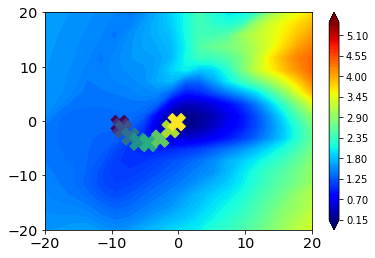

In [ ]:
data = np.load(f"{ROOT_DIR + LOSS_FILE}")

xcoords = data["xcoordinates"]
ycoords = data["ycoordinates"]
losses = data["losses"]
acc = data["accuracies"]

X, Y = np.meshgrid(xcoords, ycoords, indexing="ij")
Z = losses
fig = pyplot.figure()

## for a nicer visualization purpose,
## the filled contour plot was used instead of a simple contour plot
## The levels of the contour plot are determined based on 
## comparing the minimum and maximum of the loss values in all three RoBERTa models used in our experiment
CS = pyplot.contourf(X, Y, Z, cmap='jet', levels=np.arange(0.15, 5.5, 0.05), extend='both')

data = np.load(ROOT_DIR+PROJ_FILE_NAME)

xcoords = data["xcoordinates"]
ycoords = data["ycoordinates"]
pyplot.colorbar()

## Trajectory moves in the direction of the dark to light color.
pyplot.scatter(xcoords, ycoords, s=300, marker='X', c=np.arange(len(xcoords)))
pyplot.tick_params('y', labelsize='x-large')
pyplot.tick_params('x', labelsize='x-large')



In [ ]:
fig.savefig(
    f"./data/cs_pca_contourf", dpi=300,
    bbox_inches='tight'
)